## Analyze A/B Test Results


## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

For this project, I will be working to understand the results of an A/B test run by an e-commerce website. My goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. 

a. Read in the dataset and take a look at the top few rows here:

In [3]:
df = pd.read_csv("ab_data.csv")
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Number of rows in the dataset.

In [4]:
df.shape[0]

294478

c. The number of unique users in the dataset.

In [5]:
df['user_id'].nunique()

290584

d. The proportion of users converted.

In [6]:
df['converted'].mean()

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't line up.

In [7]:
df.query('group == "treatment" & landing_page != "new_page"').count() + df.query('group != "treatment" & landing_page == "new_page"').count()

user_id         3893
timestamp       3893
group           3893
landing_page    3893
converted       3893
dtype: int64

f. Do any of the rows have missing values?

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, I will remove these rows.

In [9]:
df2 = df.query('(group == "treatment" & landing_page == "new_page") or (group == "control" & landing_page == "old_page")')

In [10]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Questions

a. How many unique **user_id**s are in **df2**?

In [11]:
df2['user_id'].nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [12]:
duplicate = df2[df2.duplicated('user_id')]
duplicate

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


c. What is the row information for the repeat **user_id**? 

In [13]:
df2[df2['user_id'] == 773192]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**.

In [14]:
df2 = df2.drop(1899)

e. What is the probability of an individual converting regardless of the page they receive?

In [15]:
df2.converted.mean()

0.11959708724499628

f. Given that an individual was in the `control` group, what is the probability they converted?

In [16]:
control_convert = df2.query('group == "control"')['converted'].mean()
control_convert

0.1203863045004612

g. Given that an individual was in the `treatment` group, what is the probability they converted?

In [17]:
treatment_convert = df2.query('group == "treatment"')['converted'].mean()
treatment_convert

0.11880806551510564

h. What is the probability that an individual received the new page?

In [18]:
df2.query('landing_page == "new_page"')['landing_page'].value_counts() / df2.shape[0]

new_page    0.500062
Name: landing_page, dtype: float64

#### Since the probability of treament group converting is 0.119 and the probability of control group converting is 0.120, we don't have sufficient evidence to say that the treatment group leads to more conversions.

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be? 

 $$H_0: p_{new} <= p_{old}$$
 $$H_1: p_{new} > p_{old}$$

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

a. What is the **convert rate** for $p_{new}$ under the null? 

In [19]:
p_new = df2.converted.mean()
p_new

0.11959708724499628

b. What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [20]:
p_old = df2.converted.mean()
p_old

0.11959708724499628

c. What is $n_{new}$?

In [21]:
new = df2[df2.landing_page == 'new_page']
size_new = new['user_id'].count()
size_new

145310

d. What is $n_{old}$?

In [22]:
old = df2[df2.landing_page == 'old_page']
size_old = old['user_id'].count()
size_old

145274

e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [23]:
new_page_converted = np.random.binomial(1, p_new, size_new)

f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [24]:
old_page_converted = np.random.binomial(1, p_old, size_old)

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [25]:
new_page_converted.mean() - old_page_converted.mean()

-0.0016884012731219061

h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in a numpy array called **p_diffs**.

In [26]:
p_diffs = []
for _ in range(10000):
    sample_new = np.random.binomial(1, p_new, size_new)
    sample_old = np.random.binomial(1, p_old, size_old)
    sample_new_mean = sample_new.mean()
    sample_old_mean = sample_old.mean()
    p_diffs.append(sample_new_mean - sample_old_mean)

i. Plot a histogram of the **p_diffs**.

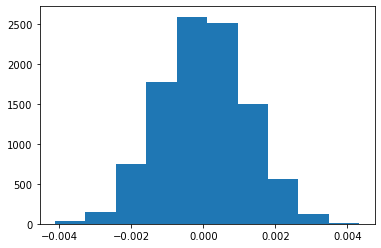

In [27]:
plt.hist(p_diffs);

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [28]:
obs_diff = treatment_convert - control_convert

In [29]:
(np.array(p_diffs) > obs_diff).mean()

0.9068

**The computed value in part j is called p-value. With a p-value as high as 0.9068, it means we fail to reject the null hypothesis, aka there's no differece between the new and old pages.**

l. We could also use a built-in to achieve similar results.

In [30]:
import statsmodels.api as sm

convert_old = df2.query('group == "control"')['converted'].sum()
convert_new = df2.query('group == "treatment"')['converted'].sum()
n_old = df2[df2['group'] == 'control'].count()[0]
n_new = df2[df2['group'] == 'treatment'].count()[0]

In [31]:
count = np.array([convert_new, convert_old])
nobs = np.array([n_new, n_old])

m. Now use `stats.proportions_ztest` to compute test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [33]:
sm.stats.proportions_ztest(count, nobs, alternative = 'larger')

(-1.3109241984234394, 0.9050583127590245)

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

**Based on the p-value, which is 0.91, we fail to reject he null hypothesis. It aligns with the findings in parts j. and k.**

<a id='regression'></a>
### Part III - A regression approach

a. In this final part, we will perform Logistic regression to get the same results.<br><br>

b. I'll use **statsmodels** to fit the regression model to see if there is a significant difference in conversion based on which page a customer receives. I first need to create a column for the intercept, and create a dummy variable column for which page each user received. I'll add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [34]:
df2['intercept'] = 1
df2[['control', 'ab_page']] = pd.get_dummies(df['group'])
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,control,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,1,0


c. Instantiate the model, and fit the model using the two columns we created in part **b.** to predict whether or not an individual converts.

In [35]:
log_mod = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
results = log_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Summary of the model.

In [36]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Tue, 22 Jun 2021   Pseudo R-squ.:               8.077e-06
Time:                        13:40:51   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

e. **The p-value is 0.190. The reason that it's different from above is that the null hypothese here is $p_{new} = p_{old}$, and alt hypothesis is $p_{new} != p_{old}$. And therefore the calculation of p-value changes since we need to consider both direction.**

f. If we consider other factors to add into regression model, we will have an opportunity to look at if other factors influence whether a viewer converts or not, as well as how other factors play a role in conversion rate holding landing page the same. The disadvantage of adding additional variables is collinearity. When we add more variables, those variables might correlate with each other.

g. Add an effect based on which country a user lives. 

Does it appear that country had an impact on conversion?  

In [37]:
countries_df = pd.read_csv('./countries.csv')
df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')

In [38]:
### Create the necessary dummy variables
country_dum = pd.get_dummies(df_new['country'])
df_new = df_new.join(country_dum)
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,control,ab_page,CA,UK,US
user_id,,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,1,0,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,0,1,0,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,0,1,0,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,1,0,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,0,1,0,1,0


In [39]:
log_mod2 = sm.Logit(df_new['converted'], df_new[['intercept','UK', 'US']])
results2 = log_mod2.fit()
results2.summary()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            2
Date:                Tue, 22 Jun 2021   Pseudo R-squ.:               1.521e-05
Time:                        13:50:17   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1984
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0375      0.026    -78.364      0.000      -2.088      -1.987
UK             0.0507      0.028      1.786      0.074      -0.005       0.106
US             0.0408      0.027      1.518      0.129      -0.012       0.093
==============================================================================
"""

**Based on the p-values of UK and US, since they are both higher than 0.05, we cannot say country has an impact on conversion rate.**

h. I would now like to look at an interaction between page and country to see if there significant effects on conversion.  

In [40]:
df_new['uk_ab_page'] = df_new['UK'] * df_new['ab_page']
df_new['us_ab_page'] = df_new['US'] * df_new['ab_page']

In [41]:
log_mod3 = sm.Logit(df_new['converted'], df_new[['intercept', 'US', 'UK', 'us_ab_page', 'uk_ab_page']])
results3 = log_mod3.fit()
results3.summary()

Optimization terminated successfully.
         Current function value: 0.366112
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290579
Method:                           MLE   Df Model:                            4
Date:                Tue, 22 Jun 2021   Pseudo R-squ.:               2.691e-05
Time:                        13:50:56   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.2205
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0375      0.026    -78.364      0.000      -2.088      -1.987
US             0.0511      0.028      1.841      0.066      -0.003       0.105
UK             0.0453      0.031      1.481      0.139      -0.015       0.105
us_ab_page    -0.0206      0.014     -1.505      0.132      -0.047       0.006
uk_ab_page     0.0108      0.023      0.475      0.635      -0.034       0.056
==============================================================================
"""

**Since all p-values are higher than 0.05, except for intercept, we cannot say the interaction between page and country has effects on conversion rate.**

i. Let's explore if timestamp can give us more information.

In [42]:
# Convert timestamp into datetime datatype.
from datetime import datetime
df_new['timestamp'] = pd.to_datetime(df_new['timestamp'])

In [43]:
df_new['timestamp'].dt.month.unique()

array([1], dtype=int64)

In [44]:
a = df_new['timestamp'].dt.day.unique()
a.sort()
a

array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24], dtype=int64)

In [45]:
b = df_new['timestamp'].dt.hour.unique()
b.sort()
b

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23], dtype=int64)

Since there is only January and day 2 - 24 in the dateset, I would focus on time of the day here.
Let's create **before_noon** and **after_noon** dummay variables based on time.

In [46]:
df_new['before_noon'] = (df_new['timestamp'].dt.hour < 12).astype(int)
df_new.head(1)

,country,timestamp,group,landing_page,converted,intercept,control,ab_page,CA,UK,US,uk_ab_page,us_ab_page,before_noon
user_id,,,,,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,1,0,0,1,0,0,0,0


Create a new model adding before_noon variable.

In [47]:
log_mod4 = sm.Logit(df_new['converted'], df_new[['intercept', 'US', 'UK', 'us_ab_page', 'uk_ab_page', 'before_noon']])
results4 = log_mod4.fit()
results4.summary()

Optimization terminated successfully.
         Current function value: 0.366104
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Tue, 22 Jun 2021   Pseudo R-squ.:               4.675e-05
Time:                        13:51:19   Log-Likelihood:            -1.0638e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                   0.07673
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
intercept      -2.0257      0.027    -76.074      0.000      -2.078      -1.973
US              0.0509      0.028      1.835      0.066      -0.003       0.105
UK              0.0452      0.031      1.477      0.140      -0.015       0.105
us_ab_page     -0.0206      0.014     -1.508      0.131      -0.047       0.006
uk_ab_page      0.0108      0.023      0.473      0.636      -0.034       0.056
before_noon    -0.0235      0.011     -2.054      0.040      -0.046      -0.001
===============================================================================
"""

**The p-value of before_noon is 0.04, which is smaller than 0.05. We can say time of the day does have an impact on conversion rate.**

## Resources

https://stackoverflow.com/questions/53148935/one-sample-test-for-proportion

https://stackoverflow.com/questions/32072076/find-the-unique-values-in-a-column-and-then-sort-them

https://stackoverflow.com/questions/51603690/extract-day-and-month-from-a-datetime-object

https://stackoverflow.com/questions/37164035/dummy-variables-in-pandas-based-on-values

<a id='conclusions'></a>
## Conclusions

Based on the p-values of different variables, we only saw that before_noon has an impact on conversion rate, and we fail to draw a conclusion that other variables, such as country and landing page, have an impact on the conversion rate. And therefore, there no enough evidence for us to say the new landing page would lead to higher conversion. So, based on the A/B testing results, we cannot implement the new page yet.